In [38]:
using Distributions
using Graphs, SimpleWeightedGraphs
using DataFrames, GLM
using Plots
using Random
using StatsBase

using BSON
using BSON: @save, @load

function num(samples_in_columns::Matrix{Float64})
    return size(samples_in_columns)[2]
end

num (generic function with 1 method)

In [2]:
struct Rect
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
end

function standard_square()
    return Rect(-0.5, 0.5, -0.5, 0.5)
end

function get_volume(region::Rect)
    return (region.xmax - region.xmin) * (region.ymax - region.ymin)
end

function get_subrectangles(region::Rect, dx::Float64, dy::Float64)
    subrects = Rect[]
    for x in region.xmin:dx:(region.xmax - dx)
        for y in region.ymin:dy:(region.ymax - dy)
            push!(subrects, Rect(x, x+dy, y, y+dy))
        end
    end
    
    return subrects
end

get_subrectangles (generic function with 1 method)

In [7]:
function draw_uniform_rectangle(region::Rect)
    return [rand(Distributions.Uniform(region.xmin, region.xmax));
            rand(Distributions.Uniform(region.ymin, region.ymax))]  
end

function sprinkle_rectangle(width::Float64, height::Float64, 
                            num_points::Int64, non_random_points::Vector{Vector{Float64}}=Vector{Float64}[])
    region = Rect(-width/2, width/2, -height/2, height/2)
    
    points = Vector{Float64}[]
    if !isempty(non_random_points)
        append!(points, non_random_points)
    end
    
    for n in 1:num_points
        push!(points, draw_uniform_rectangle(region))
    end
    
    return reduce(hcat, points)
end    


function sprinkle_standard_square(num_points::Int64, non_random_points::Vector{Vector{Float64}}=Vector{Float64}[])
    return sprinkle_rectangle(1.0, 1.0, num_points, non_random_points)
end    

sprinkle_standard_square (generic function with 2 methods)

In [8]:
function causal_distance(vector_A2B::Vector{Float64})
    η = [-1 0; 0 1.]
    return vector_A2B' * η * vector_A2B
end

function causal_distance(pointA::Vector{Float64}, pointB::Vector{Float64})
    vector_A2B = pointB - pointA
    return causal_distance(vector_A2B)
end


function euclid_distance(pointA::Vector{Float64}, pointB::Vector{Float64})
    η = [1 0; 0 1]
    diff = pointB - pointA
    return diff' * η * diff
end

function make_causal_set(sprinkled_points::Matrix{Float64})
    num_points = size(sprinkled_points)[2]
    
    causal_set = SimpleWeightedDiGraph(num_points)
    for i = 1:num_points
        for j = 1:num_points
            vector_i2j = sprinkled_points[:, j] - sprinkled_points[:, i]
            interval = causal_distance(vector_i2j)
            
            if  interval >= 0 && vector_i2j[2] > 0
                add_edge!(causal_set, i, j, -1.0)
            end
        
        end
    end 
            
    return causal_set
end

function longest_path(graph, source::Int64, destination::Int64)
    return enumerate_paths(dijkstra_shortest_paths(graph, source), destination)
end
    

longest_path (generic function with 1 method)

In [21]:
test_numbers = [100, 250, 500,1000, 2000, 3000, 4000, 5000]

data_x  = Float64[]
timings = Float64[]

for i in 1:10
    for num_events in test_numbers
        sprinkling = sprinkle_standard_square(num_events)
        time_taken = @elapsed causal_set = make_causal_set(sprinkling)
        
        push!(data_x,  num_events)
        push!(timings, time_taken)
    end
end

LoadError: UndefVarError: draw_uniform_rectangle not defined

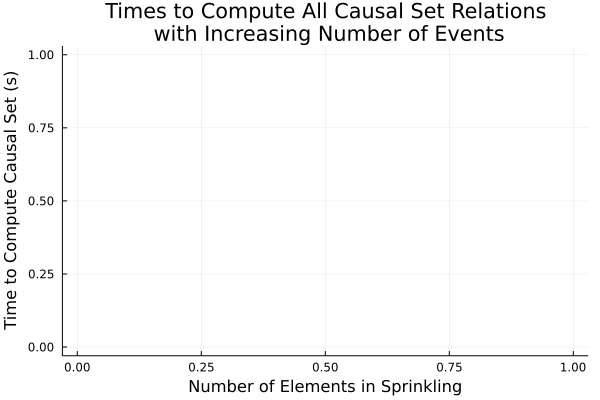

In [8]:
scatter(data_x, timings, xlabel="Number of Elements in Sprinkling", ylabel="Time to Compute Causal Set (s)", 
        title="Times to Compute All Causal Set Relations\n with Increasing Number of Events",legend=nothing)

# savefig("causa_relation_computation_times.png")

In [9]:
num_events = 3000
@time sprinkling = sprinkle_rectangle(1.0, 3.0, num_events, [[0, -1.5], [0.25, 0.5]])
@time causal_set = make_causal_set(sprinkling)
num_points = nv(causal_set)
print("Created a causal set with ", num_points, " events.\n")

@time worldline_indices = longest_path(causal_set, 1, 2)
worldline = sprinkling[:, worldline_indices];

print(length(worldline))

  0.000199 seconds (3.02 k allocations: 393.109 KiB)
  5.125273 seconds (90.12 M allocations: 5.913 GiB, 13.18% gc time)
Created a causal set with 3002 events.
  5.379353 seconds (3.02 k allocations: 4.317 MiB, 0.19% compilation time)
168

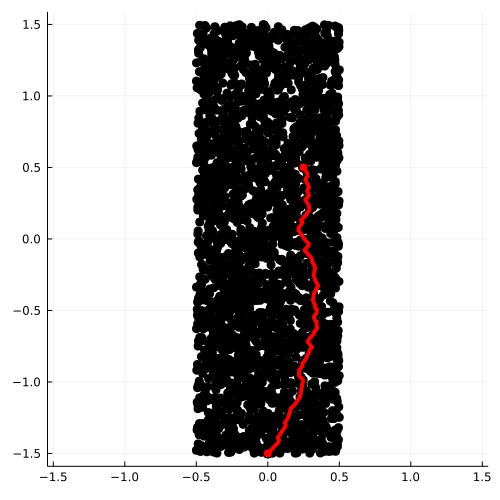

In [10]:
colors = repeat([:black], num_points)
colors[1:2] .= :red

scatter(sprinkling[1, :], sprinkling[2,:], ms=5, legend=nothing, color=colors,
        size=(500,500), aspect_ratio=1)
scatter!(sprinkling[1, 1:2], sprinkling[2, 1:2], ms=5, color=:red)

plot!(worldline[1, :], worldline[2,:], lw=4, color=:red)


In [11]:
function maximal_chain_length(destination::Vector{Float64}, density::Float64, 
                              max_number::Int64, num_subsquares_across::Int64)
    
end

maximal_chain_length (generic function with 1 method)

In [13]:
function gather_propertime_data(total_event_numbers::Vector{Int64}, num_samples::Int64=10)
    # Will save: Number of events in region, propertime between pair, length of maximal chain between pair
    collection = Matrix{Float64}[]
    
    for num_events in total_event_numbers
        trialdata  = Vector{Float64}[]
        
        for _ in 1:5
            height = 10.0
            sprinkling = sprinkle_rectangle(1.0, height, num_events, [[0, -height/2]])
            causal_set = make_causal_set(sprinkling)
            num_points = nv(causal_set)

            random_ends   = rand(1:num_points, num_samples)

                for i in 1:num_samples
                    a = 1
                    b = random_ends[i]
                    propertime = causal_distance(sprinkling[:, a], sprinkling[:, b])

                    worldline_indices = longest_path(causal_set, a, b)
                    worldline = sprinkling[:, worldline_indices];

                    datum = [num_points, propertime, length(worldline)]
                    push!(trialdata, datum)
                end

        end
        
        push!(collection, reduce(hcat, trialdata))
    end

    return collection
end

gather_propertime_data (generic function with 2 methods)

In [15]:
num_samples = 350
data = @time gather_propertime_data([500, 1000, 5000], num_samples)

98796.851334 seconds (1.32 G allocations: 117.455 GiB, 0.02% gc time)


3-element Vector{Matrix{Float64}}:
 [501.0 501.0 … 501.0 501.0; 46.463641656766086 89.7770081154366 … 0.2423315467568664 -0.014030339897992405; 138.0 184.0 … 8.0 0.0]
 [1001.0 1001.0 … 1001.0 1001.0; 51.43314388607959 19.31912781755973 … 69.4618875956046 2.077665794254601; 188.0 116.0 … 218.0 36.0]
 [5001.0 5001.0 … 5001.0 5001.0; 49.601369356801186 11.139568997332958 … 66.23353785513561 55.03604065955128; 418.0 198.0 … 508.0 460.0]

In [122]:
descriptor = "I sprinkled the events randomly into a 1x10 region of spacetime, computed the causal set relations, and then sampled 350 points randomly.\n
              The data points were collected by computing the spacetime interval and maximal chain length between these 30 points and a single reference 
              point in the center-bottom of the region. This was repeated for causal sets derived from 500 to 5000 sprinkled events. The whole process
              took about 27 hours (98796.851334 seconds (1.32 G allocations: 117.455 GiB, 0.02% gc time)."

bson("propertime_chain_data_7Dec2021.bson", data=data, description=descriptor)

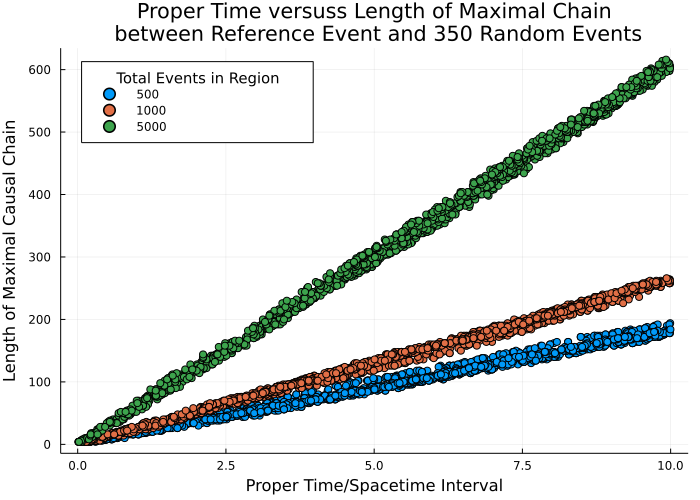

In [85]:
p = plot(xlabel="Proper Time/Spacetime Interval", ylabel="Length of Maximal Causal Chain",
         title="Proper Time versuss Length of Maximal Chain\n between Reference Event and $(num_samples) Random Events",
         legendtitle="Total Events in Region", legendtitlefontsize=10, legendposition=:topleft, 
         size=(700, 500))
for (i, trialdata) in enumerate(data)
    total_num_events = convert(Int64, data[i][1,1])
    
    propertimes = sqrt.(trialdata[2, :])
    scatter!(p, propertimes, trialdata[3, :], label="$(total_num_events-1)")
end

display(p)

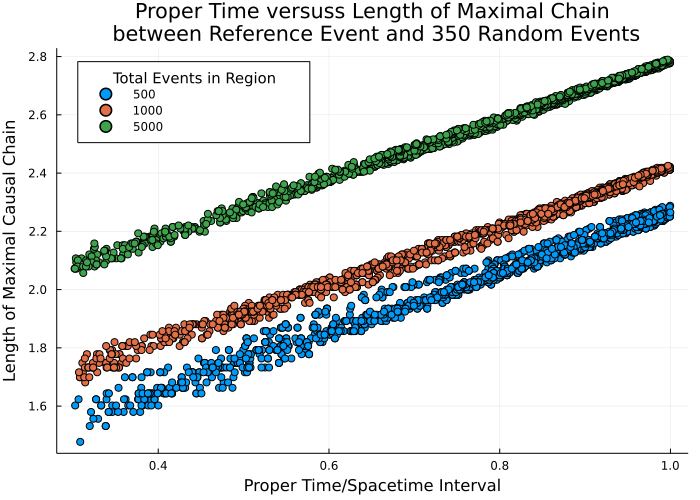

1.0012941538955813	18.275882591672996
0.9973276711196496	26.157257507010964
1.0090752729267323	59.407147079626306


In [144]:
p = plot(xlabel="Proper Time/Spacetime Interval", ylabel="Length of Maximal Causal Chain",
         title="Proper Time versuss Length of Maximal Chain\n between Reference Event and $(num_samples) Random Events",
         legendtitle="Total Events in Region", legendtitlefontsize=10, legendposition=:topleft, 
         size=(700, 500))

slopes = Float64[]
for (i, trialdata) in enumerate(data)
    total_num_events = convert(Int64, data[i][1,1])
    propertimes = sqrt.(trialdata[2, :])

    range = propertimes .> 2
    to_fit = DataFrame(X=log.(propertimes[range]), Y=log.(data[i][3, range]));
    ols = lm(@formula(Y ~ X), to_fit)
    
    power = coef(ols)[2]
    slope = exp(coef(ols)[1])
    push!(slopes, slope)
    print(power, "\t", slope, "\n")
    
    scatter!(p, log.(10, propertimes[range]), log.(10, trialdata[3, range]), label="$(total_num_events-1)")
end

display(p)

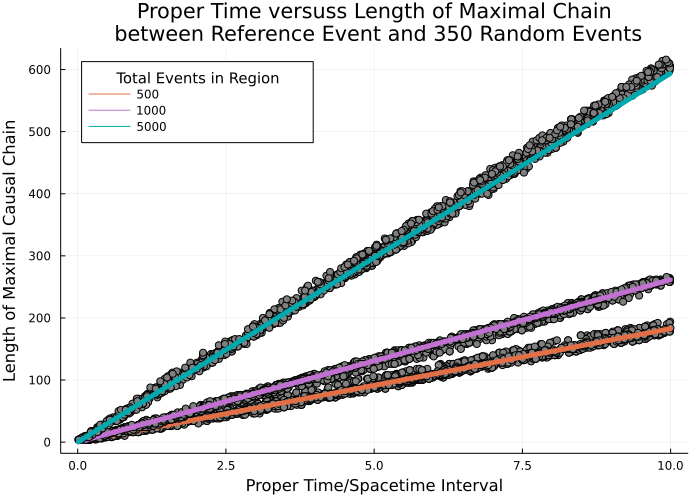

In [145]:
p = plot(xlabel="Proper Time/Spacetime Interval", ylabel="Length of Maximal Causal Chain",
         title="Proper Time versuss Length of Maximal Chain\n between Reference Event and $(num_samples) Random Events",
         legendtitle="Total Events in Region", legendtitlefontsize=10, legendposition=:topleft, 
         size=(700, 500))
for (i, trialdata) in enumerate(data)
    total_num_events = convert(Int64, data[i][1,1])
    
    propertimes = sqrt.(trialdata[2, :])
    lines = slopes[i]*propertimes
    scatter!(p, propertimes, trialdata[3, :],  label=nothing,color=:grey)
    plot!(propertimes, lines, label="$(total_num_events-1)", lw=5)
end

display(p)

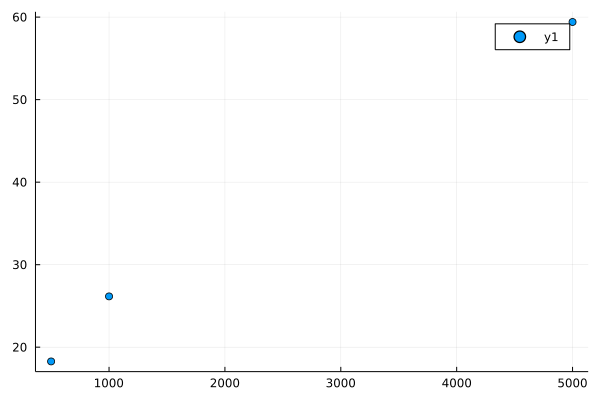

In [146]:
scatter([500, 1000, 5000], slopes)